# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [3]:
!pip install pymongo

     |████████████████████████████████| 509 kB 11.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install pymongo[srv]

     |████████████████████████████████| 188 kB 13.3 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [6]:
!pip install tweepy

     |████████████████████████████████| 147 kB 20.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [8]:
!pip install twitter

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [9]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [10]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [11]:
client = MongoClient(mongod_connect)
db = client.gp31 # use or create a database named demo
tweet_collection = db.tweet_collection #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the REST API to Collect Tweets

Authorize the REST API 

In [12]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [15]:
count = 100 
geocode = "47.650589,-100.437012,150mi"  
q = "COVID19"                               

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [16]:
search_results = rest_api.search.tweets(count=count, q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])
    except:
        pass

'Wed Dec 09 21:33:56 +0000 2020'
'Wed Dec 09 21:23:23 +0000 2020'
'Wed Dec 09 21:02:30 +0000 2020'
'Wed Dec 09 20:52:13 +0000 2020'
'Wed Dec 09 20:50:44 +0000 2020'
'Wed Dec 09 20:47:19 +0000 2020'
'Wed Dec 09 20:45:35 +0000 2020'
'Wed Dec 09 20:41:05 +0000 2020'
'Wed Dec 09 20:36:23 +0000 2020'
'Wed Dec 09 20:34:06 +0000 2020'
'Wed Dec 09 20:34:05 +0000 2020'
'Wed Dec 09 20:32:41 +0000 2020'
'Wed Dec 09 20:32:20 +0000 2020'
'Wed Dec 09 20:31:54 +0000 2020'
'Wed Dec 09 20:28:38 +0000 2020'
'Wed Dec 09 20:22:10 +0000 2020'
'Wed Dec 09 20:21:52 +0000 2020'
'Wed Dec 09 20:09:10 +0000 2020'
'Wed Dec 09 20:05:32 +0000 2020'
'Wed Dec 09 19:44:38 +0000 2020'
'Wed Dec 09 19:44:19 +0000 2020'
'Wed Dec 09 19:43:50 +0000 2020'
'Wed Dec 09 19:38:21 +0000 2020'
'Wed Dec 09 19:23:13 +0000 2020'
'Wed Dec 09 18:31:04 +0000 2020'
'Wed Dec 09 18:23:11 +0000 2020'
'Wed Dec 09 18:22:58 +0000 2020'
'Wed Dec 09 18:20:48 +0000 2020'
'Wed Dec 09 18:19:30 +0000 2020'
'Wed Dec 09 18:12:52 +0000 2020'
'Wed Dec 0

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [17]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Wed Dec 09 10:42:01 +0000 2020'
'Wed Dec 09 10:38:06 +0000 2020'
'Wed Dec 09 10:17:51 +0000 2020'
'Wed Dec 09 09:40:39 +0000 2020'
'Wed Dec 09 09:24:50 +0000 2020'
'Wed Dec 09 09:13:32 +0000 2020'
'Wed Dec 09 09:00:50 +0000 2020'
'Wed Dec 09 06:43:42 +0000 2020'
'Wed Dec 09 06:22:43 +0000 2020'
'Wed Dec 09 05:54:38 +0000 2020'
'Wed Dec 09 05:53:48 +0000 2020'
'Wed Dec 09 05:53:20 +0000 2020'
'Wed Dec 09 05:52:02 +0000 2020'
'Wed Dec 09 05:11:06 +0000 2020'
'Wed Dec 09 05:09:11 +0000 2020'
'Wed Dec 09 04:42:16 +0000 2020'
'Wed Dec 09 04:27:22 +0000 2020'
'Wed Dec 09 03:57:21 +0000 2020'
'Wed Dec 09 03:46:43 +0000 2020'
'Wed Dec 09 03:38:53 +0000 2020'
'Wed Dec 09 03:13:08 +0000 2020'
'Wed Dec 09 03:02:47 +0000 2020'
'Wed Dec 09 02:53:37 +0000 2020'
'Wed Dec 09 02:35:44 +0000 2020'
'Wed Dec 09 02:33:40 +0000 2020'
'Wed Dec 09 02:31:26 +0000 2020'
'Wed Dec 09 02:08:20 +0000 2020'
'Wed Dec 09 02:03:16 +0000 2020'
'Wed Dec 09 02:01:48 +0000 2020'
'Wed Dec 09 01:59:47 +0000 2020'
'Wed Dec 0

'Tue Dec 08 03:54:52 +0000 2020'
'Tue Dec 08 03:54:50 +0000 2020'
'Tue Dec 08 03:49:35 +0000 2020'
'Tue Dec 08 03:25:09 +0000 2020'
'Tue Dec 08 02:59:32 +0000 2020'
'Tue Dec 08 02:48:52 +0000 2020'
'Tue Dec 08 02:29:08 +0000 2020'
'Tue Dec 08 02:18:37 +0000 2020'
'Tue Dec 08 02:08:08 +0000 2020'
'Tue Dec 08 02:00:49 +0000 2020'
'Tue Dec 08 01:58:50 +0000 2020'
'Tue Dec 08 01:42:49 +0000 2020'
'Tue Dec 08 01:38:08 +0000 2020'
'Tue Dec 08 01:38:05 +0000 2020'
'Tue Dec 08 01:36:36 +0000 2020'
'Tue Dec 08 01:35:59 +0000 2020'
'Tue Dec 08 01:31:22 +0000 2020'
'Tue Dec 08 01:14:35 +0000 2020'
'Tue Dec 08 01:08:42 +0000 2020'
'Tue Dec 08 01:07:42 +0000 2020'
'Tue Dec 08 01:01:51 +0000 2020'
'Tue Dec 08 00:55:45 +0000 2020'
'Tue Dec 08 00:55:16 +0000 2020'
'Tue Dec 08 00:43:40 +0000 2020'
'Tue Dec 08 00:30:47 +0000 2020'
'Tue Dec 08 00:30:45 +0000 2020'
'Tue Dec 08 00:22:39 +0000 2020'
'Tue Dec 08 00:17:20 +0000 2020'
'Tue Dec 08 00:10:22 +0000 2020'
'Tue Dec 08 00:08:23 +0000 2020'
'Tue Dec 0

'Mon Dec 07 16:08:34 +0000 2020'
'Mon Dec 07 16:00:59 +0000 2020'
'Mon Dec 07 15:41:27 +0000 2020'
'Mon Dec 07 15:31:22 +0000 2020'
'Mon Dec 07 15:30:32 +0000 2020'
'Mon Dec 07 15:30:19 +0000 2020'
'Mon Dec 07 15:24:26 +0000 2020'
'Mon Dec 07 15:19:13 +0000 2020'
'Mon Dec 07 15:18:36 +0000 2020'
'Mon Dec 07 15:18:03 +0000 2020'
'Mon Dec 07 15:15:49 +0000 2020'
'Mon Dec 07 15:15:06 +0000 2020'
'Mon Dec 07 15:05:17 +0000 2020'
'Mon Dec 07 15:02:02 +0000 2020'
'Mon Dec 07 14:59:04 +0000 2020'
'Mon Dec 07 14:57:13 +0000 2020'
'Mon Dec 07 14:56:36 +0000 2020'
'Mon Dec 07 14:56:14 +0000 2020'
'Mon Dec 07 14:54:56 +0000 2020'
'Mon Dec 07 14:53:20 +0000 2020'
'Mon Dec 07 14:52:47 +0000 2020'
'Mon Dec 07 14:51:21 +0000 2020'
'Mon Dec 07 14:48:28 +0000 2020'
'Mon Dec 07 14:48:23 +0000 2020'
'Mon Dec 07 14:48:16 +0000 2020'
'Mon Dec 07 14:42:59 +0000 2020'
'Mon Dec 07 14:42:17 +0000 2020'
'Mon Dec 07 14:41:09 +0000 2020'
'Mon Dec 07 14:41:08 +0000 2020'
'Mon Dec 07 14:32:14 +0000 2020'
'Mon Dec 0

'Sun Dec 06 05:39:00 +0000 2020'
'Sun Dec 06 05:34:27 +0000 2020'
'Sun Dec 06 05:30:23 +0000 2020'
'Sun Dec 06 04:48:29 +0000 2020'
'Sun Dec 06 04:47:03 +0000 2020'
'Sun Dec 06 04:46:13 +0000 2020'
'Sun Dec 06 04:37:30 +0000 2020'
'Sun Dec 06 04:20:07 +0000 2020'
'Sun Dec 06 04:08:37 +0000 2020'
'Sun Dec 06 03:56:19 +0000 2020'
'Sun Dec 06 03:31:09 +0000 2020'
'Sun Dec 06 03:10:56 +0000 2020'
'Sun Dec 06 02:55:42 +0000 2020'
'Sun Dec 06 02:49:21 +0000 2020'
'Sun Dec 06 02:39:22 +0000 2020'
'Sun Dec 06 02:29:06 +0000 2020'
'Sun Dec 06 02:25:15 +0000 2020'
'Sun Dec 06 02:22:59 +0000 2020'
'Sun Dec 06 02:21:22 +0000 2020'
'Sun Dec 06 02:19:49 +0000 2020'
'Sun Dec 06 02:17:20 +0000 2020'
'Sun Dec 06 02:10:48 +0000 2020'
'Sun Dec 06 01:51:51 +0000 2020'
'Sun Dec 06 01:36:02 +0000 2020'
'Sun Dec 06 01:35:41 +0000 2020'
'Sun Dec 06 01:28:35 +0000 2020'
'Sun Dec 06 01:28:15 +0000 2020'
'Sun Dec 06 01:22:11 +0000 2020'
'Sun Dec 06 01:19:51 +0000 2020'
'Sun Dec 06 01:19:33 +0000 2020'
'Sun Dec 0

'Fri Dec 04 23:12:11 +0000 2020'
'Fri Dec 04 23:07:40 +0000 2020'
'Fri Dec 04 23:06:11 +0000 2020'
'Fri Dec 04 23:00:07 +0000 2020'
'Fri Dec 04 22:42:03 +0000 2020'
'Fri Dec 04 22:27:38 +0000 2020'
'Fri Dec 04 22:26:38 +0000 2020'
'Fri Dec 04 22:24:44 +0000 2020'
'Fri Dec 04 22:22:44 +0000 2020'
'Fri Dec 04 22:21:53 +0000 2020'
'Fri Dec 04 22:21:42 +0000 2020'
'Fri Dec 04 22:04:48 +0000 2020'
'Fri Dec 04 22:02:57 +0000 2020'
'Fri Dec 04 21:43:38 +0000 2020'
'Fri Dec 04 21:41:34 +0000 2020'
'Fri Dec 04 21:32:38 +0000 2020'
'Fri Dec 04 21:19:15 +0000 2020'
'Fri Dec 04 21:14:08 +0000 2020'
'Fri Dec 04 21:11:01 +0000 2020'
'Fri Dec 04 21:05:24 +0000 2020'
'Fri Dec 04 21:01:51 +0000 2020'
'Fri Dec 04 20:58:02 +0000 2020'
'Fri Dec 04 20:47:47 +0000 2020'
'Fri Dec 04 20:42:23 +0000 2020'
'Fri Dec 04 20:39:25 +0000 2020'
'Fri Dec 04 20:38:09 +0000 2020'
'Fri Dec 04 20:36:58 +0000 2020'
'Fri Dec 04 20:34:29 +0000 2020'
'Fri Dec 04 20:24:53 +0000 2020'
'Fri Dec 04 20:22:24 +0000 2020'
'Fri Dec 0

'Thu Dec 03 14:20:19 +0000 2020'
'Thu Dec 03 14:20:07 +0000 2020'
'Thu Dec 03 14:05:23 +0000 2020'
'Thu Dec 03 14:01:10 +0000 2020'
'Thu Dec 03 13:39:07 +0000 2020'
'Thu Dec 03 13:27:55 +0000 2020'
'Thu Dec 03 13:22:26 +0000 2020'
'Thu Dec 03 12:54:14 +0000 2020'
'Thu Dec 03 12:47:30 +0000 2020'
'Thu Dec 03 12:43:34 +0000 2020'
'Thu Dec 03 12:36:52 +0000 2020'
'Thu Dec 03 12:26:58 +0000 2020'
'Thu Dec 03 12:26:12 +0000 2020'
'Thu Dec 03 12:21:33 +0000 2020'
'Thu Dec 03 12:20:09 +0000 2020'
'Thu Dec 03 12:09:46 +0000 2020'
'Thu Dec 03 12:08:32 +0000 2020'
'Thu Dec 03 11:53:00 +0000 2020'
'Thu Dec 03 11:37:53 +0000 2020'
'Thu Dec 03 11:34:36 +0000 2020'
'Thu Dec 03 11:09:07 +0000 2020'
'Thu Dec 03 11:02:47 +0000 2020'
'Thu Dec 03 09:49:28 +0000 2020'
'Thu Dec 03 09:28:01 +0000 2020'
'Thu Dec 03 09:13:10 +0000 2020'
'Thu Dec 03 08:44:36 +0000 2020'
'Thu Dec 03 08:41:59 +0000 2020'
'Thu Dec 03 08:10:28 +0000 2020'
'Thu Dec 03 08:10:11 +0000 2020'
'Thu Dec 03 08:09:41 +0000 2020'
'Thu Dec 0

'Wed Dec 02 15:46:02 +0000 2020'
'Wed Dec 02 15:41:17 +0000 2020'
'Wed Dec 02 15:40:45 +0000 2020'
'Wed Dec 02 15:39:19 +0000 2020'
'Wed Dec 02 15:38:49 +0000 2020'
'Wed Dec 02 15:32:28 +0000 2020'
'Wed Dec 02 15:31:56 +0000 2020'
'Wed Dec 02 15:27:31 +0000 2020'
'Wed Dec 02 15:27:21 +0000 2020'
'Wed Dec 02 15:26:35 +0000 2020'
'Wed Dec 02 15:24:41 +0000 2020'
'Wed Dec 02 15:24:07 +0000 2020'
'Wed Dec 02 15:22:19 +0000 2020'
'Wed Dec 02 15:21:51 +0000 2020'
'Wed Dec 02 15:21:03 +0000 2020'
'Wed Dec 02 15:18:53 +0000 2020'
'Wed Dec 02 15:18:07 +0000 2020'
'Wed Dec 02 15:18:02 +0000 2020'
'Wed Dec 02 15:16:42 +0000 2020'
'Wed Dec 02 15:06:31 +0000 2020'
'Wed Dec 02 15:06:19 +0000 2020'
'Wed Dec 02 15:00:17 +0000 2020'
'Wed Dec 02 14:46:51 +0000 2020'
'Wed Dec 02 14:31:35 +0000 2020'
'Wed Dec 02 14:27:17 +0000 2020'
'Wed Dec 02 14:25:58 +0000 2020'
'Wed Dec 02 14:25:55 +0000 2020'
'Wed Dec 02 14:14:16 +0000 2020'
'Wed Dec 02 14:13:30 +0000 2020'
'Wed Dec 02 14:11:08 +0000 2020'
'Wed Dec 0

'Mon Nov 30 23:49:50 +0000 2020'
'Mon Nov 30 23:38:47 +0000 2020'
'Mon Nov 30 23:38:00 +0000 2020'
'Mon Nov 30 23:17:38 +0000 2020'
'Mon Nov 30 23:15:58 +0000 2020'
'Mon Nov 30 23:15:43 +0000 2020'
'Mon Nov 30 23:15:33 +0000 2020'
'Mon Nov 30 23:13:48 +0000 2020'
'Mon Nov 30 23:13:22 +0000 2020'
'Mon Nov 30 23:08:03 +0000 2020'
'Mon Nov 30 23:02:19 +0000 2020'
'Mon Nov 30 22:50:10 +0000 2020'
'Mon Nov 30 22:44:05 +0000 2020'
'Mon Nov 30 22:43:37 +0000 2020'
'Mon Nov 30 22:33:10 +0000 2020'
'Mon Nov 30 22:29:44 +0000 2020'
'Mon Nov 30 22:21:06 +0000 2020'
'Mon Nov 30 22:16:00 +0000 2020'
'Mon Nov 30 22:07:07 +0000 2020'
'Mon Nov 30 21:49:49 +0000 2020'
'Mon Nov 30 21:46:57 +0000 2020'
'Mon Nov 30 20:58:22 +0000 2020'
'Mon Nov 30 20:49:37 +0000 2020'
'Mon Nov 30 20:43:51 +0000 2020'
'Mon Nov 30 20:34:44 +0000 2020'
'Mon Nov 30 19:57:50 +0000 2020'
'Mon Nov 30 19:48:45 +0000 2020'
'Mon Nov 30 19:42:40 +0000 2020'
'Mon Nov 30 19:42:29 +0000 2020'
'Mon Nov 30 19:39:36 +0000 2020'
'Mon Nov 3

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [18]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

9700
8118


Create a text index and print the Tweets containing specific keywords. 

In [19]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [20]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pprint to display tweets

In [21]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: John flores
text: RT @OldKentuckyHome: @kylegriffin1 You are not up - in EC or popular vote

Counting every vote isn't stealing an election

Votes aren't bei…
----
name: Colin Schäfer
text: There is a pandemic making in person voting dangerous.
Republicans still vote in person under those circumstances,… https://t.co/IKKy85qn8I
----
name: Shela Connelly
text: @OhheyKell You can register to vote on election day in Wisconsin. Look up their voting laws, they're some of the st… https://t.co/KsBHmbwsHE
----
name: Vintage Enterprise Memorabilia
text: PELOSI ADMITS SHE HELD UP THE COVID RELIEF FUNDING
#cheated #relief #election #joebiden #trump #voting #votes… https://t.co/DLvlJ1aeC6
----
name: RealGirl
text: RT @clairecmc: Wait wait. Fraud fraud. Late breaking vote count. Oh never mind, only applies if D is winning vote count after Election Day.…
----
name: marc seddon
text: RT @clairecmc: Wait wait. Fraud fraud. Late breaking vote count. Oh never mind, only applies if D is winnin

In [22]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pandas to display tweets

In [23]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,quoted_status_id_str,quoted_status,quoted_status_permalink,quote_count,reply_count,filter_level,timestamp_ms,display_text_range,extended_tweet,extended_entities
0,5faae68ba2ec50aecec04e33,Tue Nov 10 03:01:13 +0000 2020,1325996906980364289,1325996906980364289,RT @OldKentuckyHome: @kylegriffin1 You are not...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5faaee8030765ecaaa07a89f,Tue Nov 10 19:44:30 +0000 2020,1326249392697962506,1326249392697962506,There is a pandemic making in person voting da...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5faae682a2ec50aecec04c93,Tue Nov 10 07:40:24 +0000 2020,1326067167197007872,1326067167197007872,@OhheyKell You can register to vote on electio...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.326067e+18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5fd1434a308c06d1efba4756,Tue Dec 08 22:25:24 +0000 2020,1336436743613140994,1336436743613140994,PELOSI ADMITS SHE HELD UP THE COVID RELIEF FUN...,True,"{'hashtags': [{'text': 'cheated', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5faae4cfa2ec50aecec0459e,Tue Nov 10 19:06:50 +0000 2020,1326239913105297409,1326239913105297409,RT @clairecmc: Wait wait. Fraud fraud. Late br...,False,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1326237307620511744,{'created_at': 'Tue Nov 10 18:56:29 +0000 2020...,"{'url': 'https://t.co/ZQyUlGLori', 'expanded':...",0.0,0.0,low,1605035210287,NaN,NaN,NaN
5,5faae4cda2ec50aecec04547,Tue Nov 10 19:06:48 +0000 2020,1326239905996042241,1326239905996042241,RT @clairecmc: Wait wait. Fraud fraud. Late br...,False,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1326237307620511744,{'created_at': 'Tue Nov 10 18:56:29 +0000 2020...,"{'url': 'https://t.co/ZQyUlGLori', 'expanded':...",0.0,0.0,low,1605035208592,NaN,NaN,NaN
6,5faae4c9a2ec50aecec04458,Tue Nov 10 19:06:43 +0000 2020,1326239886555435008,1326239886555435008,RT @clairecmc: Wait wait. Fraud fraud. Late br...,False,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1326237307620511744,{'created_at': 'Tue Nov 10 18:56:29 +0000 2020...,"{'url': 'https://t.co/ZQyUlGLori', 'expanded':...",0.0,0.0,low,1605035203957,NaN,NaN,NaN
7,5faae4cca2ec50aecec0451b,Tue Nov 10 19:06:47 +0000 2020,1326239902795788289,1326239902795788289,Guess they should have counted votes on electi...,False,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,...,1326236352959098881,{'created_at': 'Tue Nov 10 18:52:41 +0000 2020...,"{'url': 'https://t.co/UkqDpDQyzE', 'expanded':...",0.0,0.0,low,1605035207829,NaN,NaN,NaN
8,5faae685a2ec50aecec04d3a,Tue Nov 10 04:40:00 +0000 2020,1326021768453251072,1326021768453251072,What if we held a Presidential Election and it...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5faae4cea2ec50aecec04554,Tue Nov 10 19:06:48 +0000 2020,1326239907409514497,1326239907409514497,I wonder who she voted for???\n\nI’m sure thes...,False,"{'hashtags': [], 'urls': [], 'user_mentions': ...",Na

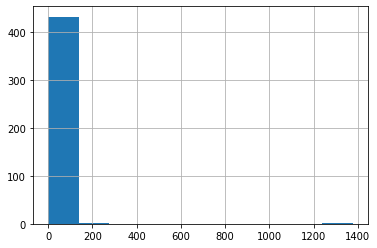

In [24]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count